###함수 저장소

1. 학습 데이터셋 비교 가시화

visualize_multiple_dataloaders([test_loader], test_loader, images_per_loader=5)

2. 실험 진행용 학습모델 저장

###1. 라이브러리 불러오기

In [ ]:
import os
import shutil
import random
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###2. 데이터셋 정의 - 비오염

In [ ]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

In [ ]:
def visualize_multiple_dataloaders(dataloaders, trainloader, images_per_loader=5):
    num_loaders = len(dataloaders)
    classes = trainloader.dataset.classes

    # 플롯 크기 설정
    plt.figure(figsize=(8,8))

    for i, loader in enumerate(dataloaders):
        # 각 DataLoader에서 배치 하나 가져오기
        batch = next(iter(loader))
        images, labels = batch
        images = torch.clamp(images, 0, 1)  # 이미지를 0과 1 사이로 클리핑하여 표시 문제 방지

        # 각 DataLoader에서 선택한 이미지 수만큼 시각화
        for j in range(images_per_loader):
            idx = i * images_per_loader + j
            plt.subplot(num_loaders, images_per_loader, idx + 1)
            plt.imshow(images[j].permute(1, 2, 0))  # 이미지 차원 변경: (C, H, W) -> (H, W, C)
            plt.title(classes[labels[j].item()])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

###3. 신경망 코딩 - ResNet50

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

###4. 신경망 학습과 테스트 진행

In [ ]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [ ]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

###데이터의 오염 적용 - 순서에 따른 변화

In [ ]:
class AugmentedDataset(Dataset):
    """
    CIFAR-10 데이터셋에 다양한 공격을 추가하는 클래스입니다.

    Attributes:
    - dataset: 원본 데이터셋
    - label_attack: Label 오염 활성화 여부
    - overlay_attack: 이미지 겹침 활성화 여부
    - attacked_ratio: 공격 비율
    - alpha: 이미지 겹침 공격의 혼합 비율
    - attack_order: 공격 순서 ("label_first" 또는 "overlay_first")
    """
    def __init__(self, dataset, attacked_ratio=0.2, alpha=0.5, label_attack=True, overlay_attack=True, attack_order="label_first"):
        """
        AugmentedDataset 객체를 초기화합니다.

        Args:
        - dataset: CIFAR-10 데이터셋 객체
        - attacked_ratio: 공격 비율 (라벨 오염 및 이미지 겹침에 공통 적용)
        - alpha: 이미지 겹침 혼합 비율
        - label_attack: 라벨 오염 활성화 여부
        - overlay_attack: 이미지 겹침 활성화 여부
        - attack_order: 공격 순서 ("label_first" 또는 "overlay_first")
        """
        self.dataset = dataset
        self.attacked_ratio = attacked_ratio
        self.alpha = alpha
        self.label_attack = label_attack
        self.overlay_attack = overlay_attack
        self.attack_order = attack_order  # 공격 순서 설정

        # 공격 인덱스 설정
        self.attacked_indices = self._select_attacked_indices(self.attacked_ratio)

        # Label 오염 생성 (라벨 공격이 활성화된 경우에만)
        self.attacked_labels = self._generate_attacked_labels() if self.label_attack else None

    def _select_attacked_indices(self, ratio):
        """공격 대상 샘플의 인덱스를 선택합니다."""
        num_attack_samples = int(ratio * len(self.dataset))
        return random.sample(range(len(self.dataset)), num_attack_samples)

    def _generate_attacked_labels(self):
        """Label 오염된 라벨 리스트를 생성합니다."""
        attacked_labels = []
        for idx in range(len(self.dataset)):
            _, original_label = self.dataset[idx]
            if idx in self.attacked_indices:
                # 원래 라벨과 다른 무작위 라벨 생성
                attacked_label = original_label
                while attacked_label == original_label:
                    attacked_label = random.randint(0, 9)
                attacked_labels.append(attacked_label)
            else:
                attacked_labels.append(original_label)
        return attacked_labels

    def _apply_overlay(self, image, idx):
        """특정 이미지에 이미지 겹침 공격을 적용합니다."""
        if idx in self.attacked_indices and self.overlay_attack:
            overlay_idx = random.randint(0, len(self.dataset) - 1)
            overlay_image, _ = self.dataset[overlay_idx]
            return (1 - self.alpha) * image + self.alpha * overlay_image
        return image

    def __len__(self):
        """데이터셋의 전체 길이를 반환합니다."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        데이터셋의 특정 샘플을 반환합니다.

        Args:
        - idx: 샘플 인덱스

        Returns:
        - (Tensor, int): 이미지 텐서와 라벨
        """
        # 원본 이미지와 라벨 가져오기
        image, original_label = self.dataset[idx]

        if self.attack_order == "label_first":
            # 라벨 오염 -> 이미지 겹침
            label = self.attacked_labels[idx] if self.label_attack else original_label
            image = self._apply_overlay(image, idx)
        elif self.attack_order == "overlay_first":
            # 이미지 겹침 -> 라벨 오염
            image = self._apply_overlay(image, idx)
            label = self.attacked_labels[idx] if self.label_attack else original_label
        else:
            raise ValueError(f"Invalid attack order: {self.attack_order}. Use 'label_first' or 'overlay_first'.")

        return image, label

###실험 진행

#####1. 오염 없는 일반적 데이터 학습 과정

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.601
Accuracy: 54.92%
[Epoch 2] loss: 1.274
Accuracy: 60.81%
[Epoch 3] loss: 0.998
Accuracy: 67.37%
[Epoch 4] loss: 0.850
Accuracy: 69.88%
[Epoch 5] loss: 0.730
Accuracy: 74.62%


#####2. 오염을 적용하는 데이터 학습 과정

In [ ]:
train_set_attacked = AugmentedDataset(
    dataset=train_set,
    attacked_ratio=0.2,
    alpha=0.5,
    label_attack=False,
    overlay_attack=True,
    attack_order="label_first"
)

train_loader_attacked = DataLoader(dataset=train_set_attacked, batch_size=64, shuffle=True)

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res_1 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_1 = train_and_evaluate(model_res_1, device, train_loader_attacked, test_loader, epochs=5)

###최종 비교 그래프

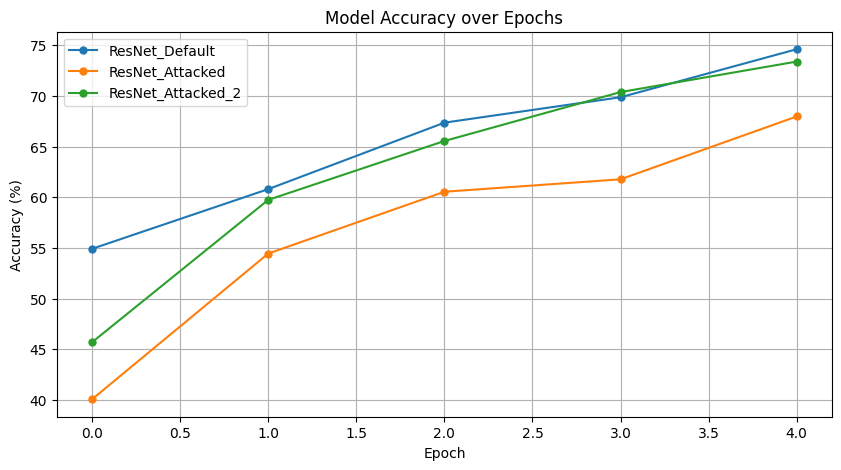

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

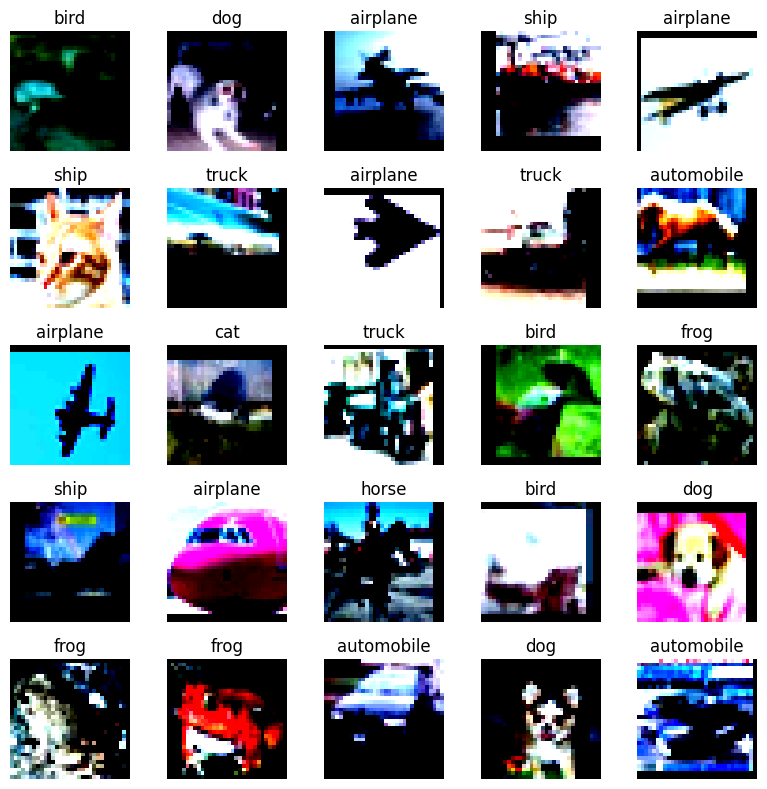

In [ ]:
visualize_multiple_dataloaders([train_loader, train_loader_1, train_loader_2, train_loader_3, train_loader_4], test_loader, images_per_loader=5)